# Librerías utilizadas:

In [107]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Importación de data set

In [108]:
data = pd.read_csv('c:\\Users\\Nico\\Desktop\\PyE\\PyEFinal/diabetes.csv')
data = data[(data['Insulin'] != 0) & (data['SkinThickness'] != 0) & (data['Glucose'] != 0)]
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1


In [109]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,3.292621,122.615776,70.646310,29.129771,155.885496,33.002036,0.526120,30.839695,0.330789
std,3.211645,30.822276,12.484668,10.507575,118.738199,7.214395,0.350386,10.199903,0.471097
min,0.000000,56.000000,24.000000,7.000000,14.000000,0.000000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,77.000000,28.400000,0.270000,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.000000,33.200000,0.452000,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Visualización de la distribución de variables
* Histograma de las distintas variables

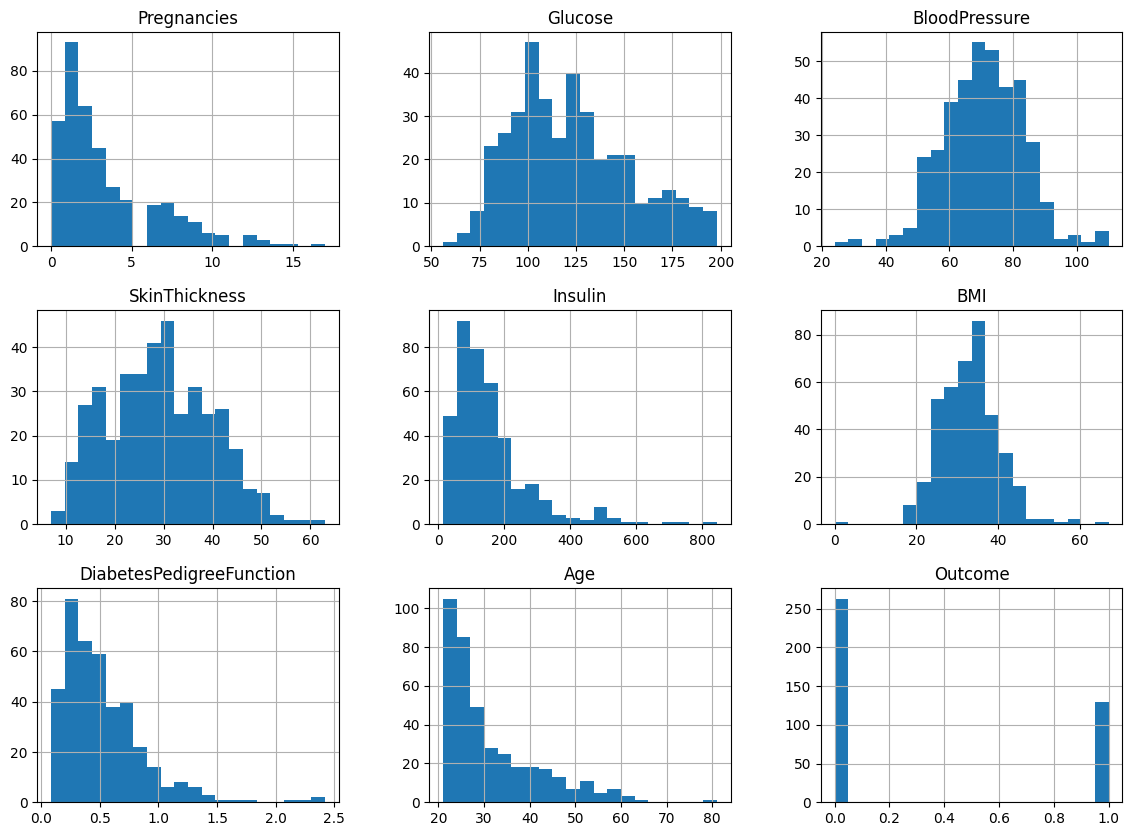

In [110]:
data.hist(bins=20, figsize=(14,10))
plt.show()

# Prueba T-Student

In [111]:
outcome_0 = data[data['Outcome'] == 0]
outcome_1 = data[data['Outcome'] == 1]

t_stat, p_val = stats.ttest_ind(outcome_0['Glucose'], outcome_1['Glucose'], equal_var=False)
print(f'T-statistic: {t_stat}, P-value: {p_val}')

T-statistic: -11.152889103682549, P-value: 3.767590913746811e-23


In [112]:
import numpy as np

mean_0 = np.mean(outcome_0['Glucose'])
mean_1 = np.mean(outcome_1['Glucose'])

std_0 = np.std(outcome_0['Glucose'], ddof=1)
std_1 = np.std(outcome_1['Glucose'], ddof=1)

n_0 = len(outcome_0['Glucose'])
n_1 = len(outcome_1['Glucose'])

t_stat_manual = (mean_0 - mean_1) / np.sqrt((std_0**2 / n_0) + (std_1**2 / n_1))

t_stat_manual

-11.152889103682549

In [113]:
numerator = ((std_0**2 / n_0) + (std_1**2 / n_1))**2
denominator = ((std_0**2 / n_0)**2 / (n_0 - 1)) + ((std_1**2 / n_1)**2 / (n_1 - 1))
df = numerator / denominator

p_value_manual = stats.t.cdf(t_stat_manual, df) * 2  

p_value_manual


3.767590913746865e-23

# Prueba Chi-Cuadrado


In [114]:
data['Glucose_Cat'] = pd.cut(data['Glucose'], bins=[0, 100, 150, data['Glucose'].max() + 1], labels=['<=100', '101-150', '>150'])

contingency_table_glucose = pd.crosstab(data['Glucose_Cat'], data['Outcome'])
chi2_glucose, p_glucose, dof_glucose, expected_glucose = stats.chi2_contingency(contingency_table_glucose)

print(contingency_table_glucose)
print(f"\nChi2: {chi2_glucose}, P-value: {p_glucose}\n")

Outcome        0   1
Glucose_Cat         
<=100        105  11
101-150      136  61
>150          22  58

Chi2: 85.73470672148675, P-value: 2.415154852443532e-19



In [115]:

observed = np.array([
    [105, 11],
    [136, 61],
    [22, 58]
])

row_totals = observed.sum(axis=1)
col_totals = observed.sum(axis=0)
total = observed.sum()

expected = np.outer(row_totals, col_totals) / total

chi2_value = ((observed - expected) ** 2 / expected).sum()

dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

p_value = 1 - stats.chi2.cdf(chi2_value, dof)

print(f"Frecuencias Observadas:\n{observed}\n")
print(f"Frecuencias Esperadas:\n{expected}\n")
print(f"Chi2: {chi2_value}")
print(f"P-value: {p_value}")
print(f"Grados de Libertad (dof): {dof}")

Frecuencias Observadas:
[[105  11]
 [136  61]
 [ 22  58]]

Frecuencias Esperadas:
[[ 77.62849873  38.37150127]
 [131.8346056   65.1653944 ]
 [ 53.53689567  26.46310433]]

Chi2: 85.73470672148675
P-value: 0.0
Grados de Libertad (dof): 2


# Regresión lineal

* Grafica de dispersion

<Axes: xlabel='Year', ylabel='Life_Expectancy'>

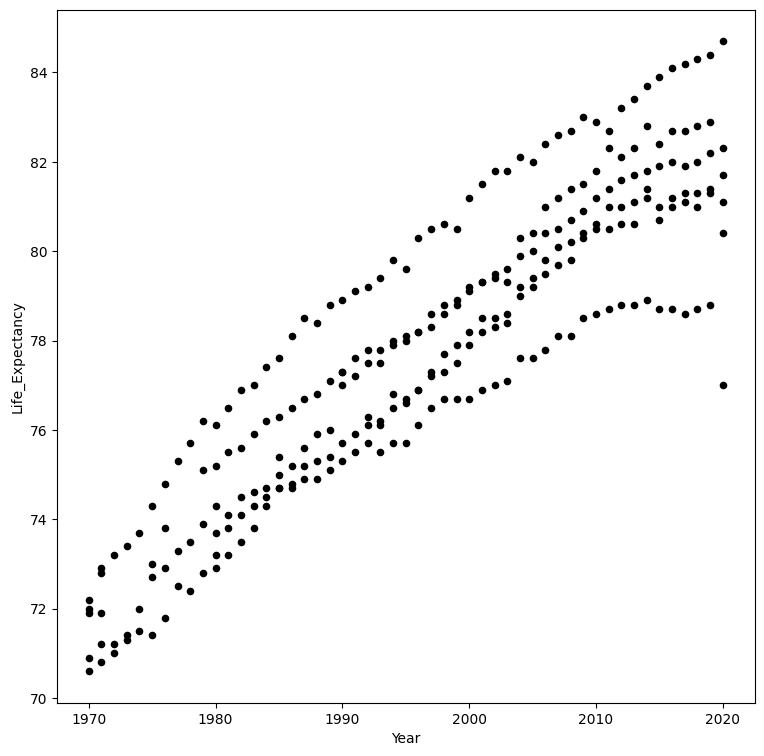

In [116]:
import seaborn as sbn
from sklearn.linear_model import LinearRegression

sbnData = sbn.load_dataset("healthexp")
sbnData.plot(kind="scatter", x="Year", y="Life_Expectancy", figsize=(9,9), color="black")


* Ajuste del modelo de regresion lineal

In [117]:
X = pd.DataFrame(sbnData["Year"])
y = sbnData["Life_Expectancy"]

ln = LinearRegression()
ln.fit(X=X, y=y)

print(f"Intercepto: {ln.intercept_}")
print(f"Coeficiente: {ln.coef_}")

Intercepto: -338.32788345841345
Coeficiente: [0.2084321]


* Valor de R cuadrado (Explica el 81%)

In [118]:
print(f"R cuadrado: {ln.score(X=X, y=y)}")

R cuadrado: 0.8139188969603898


* Prediccion para calcular los residuos

In [119]:
prediction = ln.predict(X = X)

residuals = y - prediction

residuals.describe()

count    2.740000e+02
mean    -2.318340e-14
std      1.413286e+00
min     -5.704949e+00
25%     -8.643036e-01
50%     -1.742512e-01
75%      8.314463e-01
max      2.846829e+00
Name: Life_Expectancy, dtype: float64

* Grafica de dispersion con la linea que ajusta el modelo

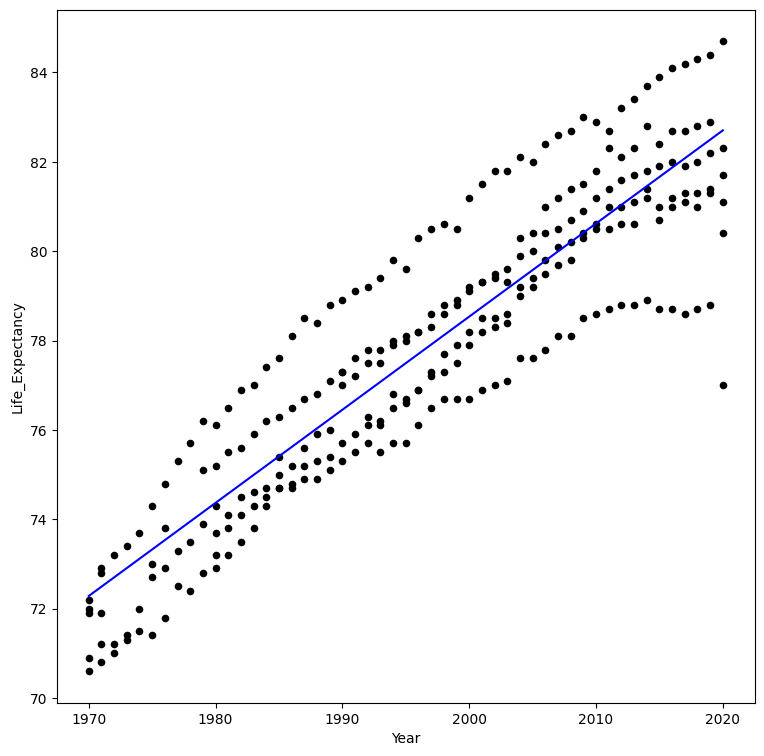

In [120]:
sbnData.plot(kind="scatter", x="Year", y="Life_Expectancy", figsize=(9,9), color="black")
plt.plot(X, prediction, color="blue")

* Grafica de residuos con distribucion normal

((array([-2.80363072, -2.50443586, -2.33479288, -2.21378165, -2.1184927 ,
       -2.03927166, -1.97109963, -1.91101976, -1.85713746, -1.80816284,
       -1.76317654, -1.72149919, -1.68261401, -1.64611834, -1.6116921 ,
       -1.57907647, -1.54805906, -1.51846333, -1.49014089, -1.46296573,
       -1.43682996, -1.41164039, -1.38731597, -1.36378579, -1.34098737,
       -1.31886541, -1.29737069, -1.27645923, -1.25609152, -1.23623197,
       -1.21684838, -1.19791151, -1.17939474, -1.16127376, -1.14352628,
       -1.12613187, -1.10907166, -1.0923283 , -1.07588568, -1.05972891,
       -1.04384414, -1.02821849, -1.01283993, -0.99769726, -0.98277997,
       -0.96807823, -0.95358281, -0.93928503, -0.92517674, -0.91125023,
       -0.89749826, -0.88391396, -0.87049085, -0.85722277, -0.84410392,
       -0.83112875, -0.81829203, -0.80558874, -0.79301415, -0.78056372,
       -0.76823313, -0.75601825, -0.74391514, -0.73192004, -0.72002933,
       -0.70823958, -0.69654745, -0.68494978, -0.67344352, -0.

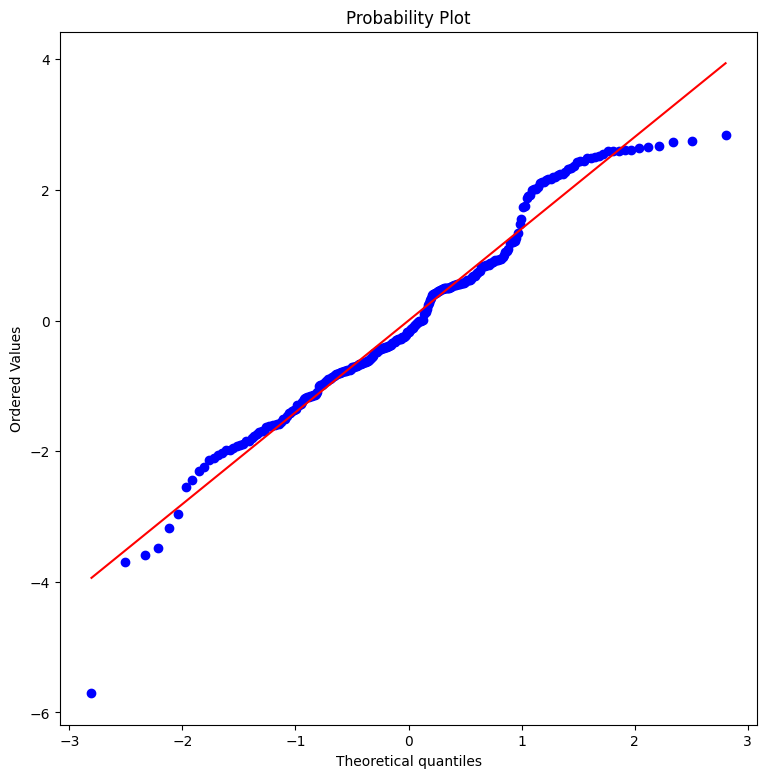

In [123]:
plt.figure(figsize=(9, 9))
stats.probplot(residuals, dist="norm", plot=plt)